# Introduction

This notebook tackles [**Playground Series – Season 5, Episode 9: Predicting the Beats-per-Minute (BPM) of Songs**](https://www.kaggle.com/competitions/playground-series-s5e9). The goal is to build a robust regression model that maps a set of audio-derived descriptors (e.g., measures of energy, loudness, vocal vs. instrumental content, rhythmic/melodic characteristics, and track duration) to a continuous BPM target. Submissions are evaluated using **Root Mean Squared Error (RMSE)**, so we’ll optimize for low average squared deviations while keeping an eye on outliers that can disproportionately affect the score.

### Why this problem is interesting

*   **Signal ↔ target alignment:** Features such as _Energy_, _AudioLoudness_, _RhythmScore_, and _VocalContent/InstrumentalScore_ are plausible physical/musical correlates of tempo, so we expect meaningful structure rather than pure noise.
*   **Real-world wrinkles:** Music contains broad BPM ranges (slow ballads to high-tempo EDM), mixed production styles, and potential edge cases (very short/long tracks), all of which can create **heteroskedasticity** and **non-linear** relationships.
*   **Modeling tradeoffs:** Simpler linear models provide transparency; tree/boosting models capture interactions and non-linearities; ensembling can blend the best of both.
    

### Plan of attack

1. **Data audit & cleaning**
   - Confirm shapes, dtypes, missingness, and constant/near-constant columns.
   - Remove non-informative identifiers (e.g., id) from training features.
   - Detect extreme values (e.g., unusually long TrackDurationMs or extreme AudioLoudness) and decide whether to cap, transform, or leave as-is.
2. **Exploratory analysis**
   - Inspect **BPM distribution** and check for multi-modality.
   - Visualize **feature distributions** and **pairwise relationships** (hexbin for dense scatter).
   - Quantify **correlations** (Pearson/Spearman) and highlight top pairs/feature↔target links.
3. **Baseline → stronger models**
   - Baseline: mean/median; then Ridge/Lasso/ElasticNet with sensible scaling.
   - Tree-based: RandomForest / XGBoost / LightGBM / CatBoost with careful CV and early stopping.
   - Optional feature engineering: simple interactions (e.g., Energy \* RhythmScore), monotonic transforms (e.g., log of duration), and polynomial terms where justified.
4. **Validation & reliability**
   - **K-Fold CV** (e.g., 5 folds) on the training set for honest performance estimates.
   - Track both **CV RMSE** and **OOF residual diagnostics** (error vs. predicted BPM, vs. duration, etc.).
   - Maintain **reproducibility**: fixed random\_state, version-locked libraries, and a clean preprocessing pipeline that mirrors test-time steps.
5. **Submission & iteration**
   - Generate predictions for test.csv, assemble the submission file, and iterate based on CV diagnostics and leaderboard feedback.

# Table of Contents

1. [Introduction](#Introduction)  
2. [Data Loading and Overview](#Data-Loading-and-Overview)
3. [Data Visualization](#Data-Visualization)
4. [Examine Original Dataset](#Examine-Original-Dataset)
5. [Dataset Comparison Report](#Dataset-Comparison-Report)
6. [Feature Engineering](#Feature-Engineering)


# Data Loading and Overview

In [1]:
# --- Standard library
import os
import random
import warnings
from pathlib import Path
from contextlib import contextmanager
from time import time

# --- Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from pandas.api.types import (
    is_categorical_dtype,
    is_numeric_dtype,
    is_object_dtype,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
import lightgbm as lgbm

# --- Notebook settings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Define some utilities functions
def configure_notebook(seed=10301, float_precision=3, max_columns=15, max_rows=25):
    """
    Configure notebook settings:
      - Disables warnings for cleaner output.
      - Sets pandas display options for better table formatting.
      - Returns a seed value for reproducibility.
    
    Parameters:
      seed (int): Random seed (default 548).
      float_precision (int): Number of decimal places for floats (default 3).
      max_columns (int): Maximum number of columns to display (default 15).
      max_rows (int): Maximum number of rows to display (default 25).

    Returns:
      int: The provided seed.
    """
    # Disable all warnings
    warnings.filterwarnings("ignore")
    
    # Set pandas display options for nicer output
    pd.options.display.float_format = f"{{:,.{float_precision}f}}".format
    pd.set_option("display.max_columns", max_columns)
    pd.set_option("display.max_rows", max_rows)

    # Set seeds for reproducibility in numpy and the standard random module
    np.random.seed(seed)
    random.seed(seed)
    
    return seed

def running_in_kaggle() -> bool:
    """
    Heuristics that are true in Kaggle notebooks:
    - Special directories exist (/kaggle/input, /kaggle/working)
    - Env var KAGGLE_KERNEL_RUN_TYPE is set
    - The kaggle_secrets module is available
    """
    try:
        if os.path.isdir("/kaggle/input") and os.path.isdir("/kaggle/working"):
            return True
        if "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
            return True
        import kaggle_secrets  # noqa: F401  (only exists in Kaggle)
        return True
    except Exception:
        return False

# Apply configuration and set random seeds for reproducibility
seed = configure_notebook()    

In [3]:
# Configurable flag to control whether GPU is used
USE_GPU = True

In [4]:
def eda_summary(df):
    # 1. Display the first few rows
    print("======== First 5 Rows ========")
    display(df.head().T)
    
    # 2. DataFrame information (data types, non-null counts, etc.)
    print("\n======== DataFrame Info ========")
    df.info()
    
    # 3. Descriptive statistics for numeric columns
    print("\n======== Descriptive Statistics (Numeric Columns) ========")
    display(df.describe())
    
    # 4. Descriptive statistics for categorical columns (if any)
    categorical_df = df.select_dtypes(include=['object', 'category'])
    print("\n======== Descriptive Statistics (Categorical Columns) ========")
    if not categorical_df.empty:
        display(categorical_df.describe())
    else:
        print("No categorical columns found.")
    
    # 5. Missing values summary
    print("\n======== Missing Values Summary ========")
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_summary = pd.DataFrame({
        "Missing Count": missing,
        "Percentage": missing_percent
    })
    display(missing_summary)
    
    # 6. Count of duplicated rows
    print("\n======== Duplicated Rows ========")
    print(f"Total duplicated rows: {df.duplicated().sum()}")
    
    # 7. Count of each data type
    print("\n======== Data Types Count ========")
    display(df.dtypes.value_counts())
    
    # 8. Correlation matrix for numeric variables (if more than one exists)
    numeric_cols = df.select_dtypes(include=[np.number])
    if numeric_cols.shape[1] > 1:
        print("\n======== Correlation Matrix (Numeric Columns) ========")
        display(numeric_cols.corr())
    else:
        print("\n======== Correlation Matrix ========")
        print("Not enough numeric columns to compute correlation.")
    
    # 9. Value counts for categorical variables with low cardinality
    print("\n======== Value Counts for Categorical Columns (Low Cardinality) ========")
    if not categorical_df.empty:
        for col in categorical_df.columns:
            if df[col].nunique() <= 20:
                print(f"\nValue Counts for '{col}':")
                display(df[col].value_counts())
    else:
        print("No categorical columns found.")


#### Read the training data and display a bit of it

In [5]:
DATA_DIR = Path('/kaggle/input/playground-series-s5e9') if running_in_kaggle() else Path('data')

training_df = pd.read_csv(DATA_DIR / 'train.csv')
training_df

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.604,-7.637,0.024,0.000,0.000,0.051,0.410,"290,715.645",0.826,147.530
1,1,0.639,-16.268,0.072,0.445,0.349,0.171,0.651,"164,519.517",0.145,136.160
2,2,0.515,-15.954,0.111,0.174,0.454,0.030,0.424,"174,495.567",0.625,55.320
3,3,0.734,-1.357,0.053,0.002,0.160,0.086,0.279,"225,567.465",0.487,147.912
4,4,0.533,-13.056,0.024,0.069,0.000,0.331,0.478,"213,960.679",0.947,89.585
...,...,...,...,...,...,...,...,...,...,...,...
524159,524159,0.797,-13.406,0.024,0.505,0.000,0.191,0.668,"135,528.319",0.004,117.831
524160,524160,0.975,-12.133,0.077,0.069,0.262,0.125,0.289,"240,709.392",0.447,89.027
524161,524161,0.543,-1.357,0.071,0.169,0.000,0.314,0.587,"344,858.232",0.719,90.759
524162,524162,0.637,-7.411,0.113,0.000,0.062,0.288,0.369,"322,710.319",0.944,140.632


#### Read the test data and display it

In [6]:
test_df = pd.read_csv(DATA_DIR / 'test.csv')
test_df

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,524164,0.410,-16.795,0.024,0.233,0.013,0.272,0.664,"302,901.550",0.425
1,524165,0.463,-1.357,0.142,0.058,0.258,0.098,0.830,"221,995.664",0.846
2,524166,0.687,-3.369,0.168,0.288,0.211,0.326,0.305,"357,724.013",0.134
3,524167,0.886,-5.598,0.118,0.000,0.377,0.134,0.488,"271,790.399",0.316
4,524168,0.637,-7.068,0.126,0.539,0.069,0.024,0.591,"277,728.538",0.481
...,...,...,...,...,...,...,...,...,...,...
174717,698881,0.333,-9.654,0.155,0.144,0.351,0.308,0.680,"255,610.419",0.428
174718,698882,0.828,-11.144,0.122,0.451,0.097,0.140,0.275,"241,204.940",0.098
174719,698883,0.569,-4.254,0.138,0.247,0.079,0.103,0.569,"127,422.295",0.193
174720,698884,0.765,-11.088,0.055,0.430,0.007,0.106,0.654,"171,586.584",0.067


#### The track duration might be comma formatted.  This helper will take care of that

In [7]:
def coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ""), errors="coerce")

In [8]:
coerce_numeric(training_df, ["TrackDurationMs"])
coerce_numeric(test_df, ["TrackDurationMs"])

#### Get rid of the 'id' column before examining the data.  Also, it'll confuse training.

In [9]:
training_df.drop('id', axis=1, inplace=True)
training_df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.604,-7.637,0.024,0.000,0.000,0.051,0.410,"290,715.645",0.826,147.530
1,0.639,-16.268,0.072,0.445,0.349,0.171,0.651,"164,519.517",0.145,136.160
2,0.515,-15.954,0.111,0.174,0.454,0.030,0.424,"174,495.567",0.625,55.320
3,0.734,-1.357,0.053,0.002,0.160,0.086,0.279,"225,567.465",0.487,147.912
4,0.533,-13.056,0.024,0.069,0.000,0.331,0.478,"213,960.679",0.947,89.585


In [10]:
# Save a copy with the ID for use later
test_ids = test_df['id'].copy()

test_df.drop('id', axis=1, inplace=True)
test_df.head()

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
0,0.410,-16.795,0.024,0.233,0.013,0.272,0.664,"302,901.550",0.425
1,0.463,-1.357,0.142,0.058,0.258,0.098,0.830,"221,995.664",0.846
2,0.687,-3.369,0.168,0.288,0.211,0.326,0.305,"357,724.013",0.134
3,0.886,-5.598,0.118,0.000,0.377,0.134,0.488,"271,790.399",0.316
4,0.637,-7.068,0.126,0.539,0.069,0.024,0.591,"277,728.538",0.481


## Exploratory Data Analysis

In [11]:
eda_summary(training_df)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.604,0.639,0.515,0.734,0.533
AudioLoudness,-7.637,-16.268,-15.954,-1.357,-13.056
VocalContent,0.024,0.072,0.111,0.053,0.024
AcousticQuality,0.000,0.445,0.174,0.002,0.069
InstrumentalScore,0.000,0.349,0.454,0.160,0.000
LivePerformanceLikelihood,0.051,0.171,0.030,0.086,0.331
MoodScore,0.410,0.651,0.424,0.279,0.478
TrackDurationMs,"290,715.645","164,519.517","174,495.567","225,567.465","213,960.679"
Energy,0.826,0.145,0.625,0.487,0.947
BeatsPerMinute,147.530,136.160,55.320,147.912,89.585



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                524164 non-null  float64
 1   AudioLoudness              524164 non-null  float64
 2   VocalContent               524164 non-null  float64
 3   AcousticQuality            524164 non-null  float64
 4   InstrumentalScore          524164 non-null  float64
 5   LivePerformanceLikelihood  524164 non-null  float64
 6   MoodScore                  524164 non-null  float64
 7   TrackDurationMs            524164 non-null  float64
 8   Energy                     524164 non-null  float64
 9   BeatsPerMinute             524164 non-null  float64
dtypes: float64(10)
memory usage: 40.0 MB

======== Descriptive Statistics (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,"524,164.000","524,164.000","524,164.000","524,164.000","524,164.000","524,164.000","524,164.000","524,164.000","524,164.000","524,164.000"
mean,0.633,-8.379,0.074,0.263,0.118,0.178,0.556,"241,903.693",0.501,119.035
std,0.157,4.616,0.050,0.223,0.132,0.118,0.225,"59,326.602",0.290,26.468
min,0.077,-27.510,0.024,0.000,0.000,0.024,0.026,"63,973.000",0.000,46.718
25%,0.516,-11.552,0.024,0.069,0.000,0.078,0.404,"207,099.877",0.255,101.070
50%,0.635,-8.252,0.066,0.243,0.074,0.166,0.565,"243,684.058",0.512,118.748
75%,0.739,-4.912,0.107,0.397,0.204,0.269,0.717,"281,851.659",0.746,136.687
max,0.975,-1.357,0.256,0.995,0.869,0.600,0.978,"464,723.228",1.000,206.037



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
LivePerformanceLikelihood,0,0.000
MoodScore,0,0.000
TrackDurationMs,0,0.000
Energy,0,0.000
BeatsPerMinute,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    10
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
RhythmScore,1.000,-0.017,0.009,0.028,0.011,0.032,-0.009,-0.018,-0.147,0.005
AudioLoudness,-0.017,1.000,-0.009,-0.013,0.004,-0.022,-0.027,0.005,0.192,-0.003
VocalContent,0.009,-0.009,1.000,0.009,-0.018,-0.120,0.059,0.018,0.016,0.005
AcousticQuality,0.028,-0.013,0.009,1.000,0.003,0.010,0.037,-0.023,-0.418,-0.001
InstrumentalScore,0.011,0.004,-0.018,0.003,1.000,-0.002,0.005,0.009,-0.020,0.002
LivePerformanceLikelihood,0.032,-0.022,-0.120,0.010,-0.002,1.000,0.015,0.005,-0.266,0.003
MoodScore,-0.009,-0.027,0.059,0.037,0.005,0.015,1.000,-0.015,-0.242,0.007
TrackDurationMs,-0.018,0.005,0.018,-0.023,0.009,0.005,-0.015,1.000,0.049,0.007
Energy,-0.147,0.192,0.016,-0.418,-0.020,-0.266,-0.242,0.049,1.000,-0.004
BeatsPerMinute,0.005,-0.003,0.005,-0.001,0.002,0.003,0.007,0.007,-0.004,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


#### Show the statistics and structure of the test data

In [12]:
eda_summary(test_df)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.410,0.463,0.687,0.886,0.637
AudioLoudness,-16.795,-1.357,-3.369,-5.598,-7.068
VocalContent,0.024,0.142,0.168,0.118,0.126
AcousticQuality,0.233,0.058,0.288,0.000,0.539
InstrumentalScore,0.013,0.258,0.211,0.377,0.069
LivePerformanceLikelihood,0.272,0.098,0.326,0.134,0.024
MoodScore,0.664,0.830,0.305,0.488,0.591
TrackDurationMs,"302,901.550","221,995.664","357,724.013","271,790.399","277,728.538"
Energy,0.425,0.846,0.134,0.316,0.481



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174722 entries, 0 to 174721
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   RhythmScore                174722 non-null  float64
 1   AudioLoudness              174722 non-null  float64
 2   VocalContent               174722 non-null  float64
 3   AcousticQuality            174722 non-null  float64
 4   InstrumentalScore          174722 non-null  float64
 5   LivePerformanceLikelihood  174722 non-null  float64
 6   MoodScore                  174722 non-null  float64
 7   TrackDurationMs            174722 non-null  float64
 8   Energy                     174722 non-null  float64
dtypes: float64(9)
memory usage: 12.0 MB

======== Descriptive Statistics (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
count,"174,722.000","174,722.000","174,722.000","174,722.000","174,722.000","174,722.000","174,722.000","174,722.000","174,722.000"
mean,0.633,-8.377,0.074,0.263,0.117,0.178,0.556,"241,753.736",0.501
std,0.157,4.622,0.050,0.223,0.132,0.118,0.226,"59,103.897",0.291
min,0.141,-27.443,0.024,0.000,0.000,0.024,0.026,"63,973.000",0.000
25%,0.515,-11.550,0.024,0.069,0.000,0.078,0.404,"207,518.151",0.254
50%,0.635,-8.253,0.066,0.242,0.074,0.166,0.566,"243,584.585",0.512
75%,0.739,-4.904,0.107,0.397,0.203,0.268,0.717,"281,737.445",0.746
max,0.975,-1.357,0.259,0.995,0.681,0.600,0.978,"449,288.808",1.000



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
LivePerformanceLikelihood,0,0.000
MoodScore,0,0.000
TrackDurationMs,0,0.000
Energy,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    9
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy
RhythmScore,1.000,-0.019,0.008,0.035,0.004,0.033,-0.010,-0.021,-0.151
AudioLoudness,-0.019,1.000,-0.010,-0.015,0.010,-0.019,-0.027,0.006,0.189
VocalContent,0.008,-0.010,1.000,0.009,-0.016,-0.119,0.060,0.021,0.020
AcousticQuality,0.035,-0.015,0.009,1.000,0.004,0.018,0.034,-0.017,-0.423
InstrumentalScore,0.004,0.010,-0.016,0.004,1.000,-0.003,0.005,0.009,-0.020
LivePerformanceLikelihood,0.033,-0.019,-0.119,0.018,-0.003,1.000,0.017,0.005,-0.269
MoodScore,-0.010,-0.027,0.060,0.034,0.005,0.017,1.000,-0.017,-0.240
TrackDurationMs,-0.021,0.006,0.021,-0.017,0.009,0.005,-0.017,1.000,0.045
Energy,-0.151,0.189,0.020,-0.423,-0.020,-0.269,-0.240,0.045,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


# Data Visualization

#### Target & Feature distributions — What & why
We first examine the distribution of **BeatsPerMinute** and the marginal distributions of key numeric features.
This reveals central tendency, spread, skewness, and potential multi‑modality (e.g., half/double‑time clusters).
These insights inform scaling and simple transforms (e.g., `log1p(TrackDurationMs)`) and guard against outlier‑driven RMSE errors.

In [13]:
def detect_target(df):
    """Infer the target column name from common candidates."""
    candidates = ["BPM", "bpm", "tempo", "Tempo", "target", "BeatsPerMinute"]
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError("Could not detect target column. Set `target_col` manually.")

def numeric_features(df, exclude=None):
    exclude = set(exclude or [])
    return [c for c in df.select_dtypes(include="number").columns if c not in exclude]

def safe_sample(df, n=200_000, seed=42):
    if len(df) > n:
        return df.sample(n, random_state=seed)
    return df

def describe_df(df):
    target = detect_target(df)
    nums   = numeric_features(df, exclude=[target])
    return target, nums

t_target, t_num = describe_df(training_df)
print(f"Detected target: {t_target}")
print(f"Numeric features (excluding target): {len(t_num)} columns")

Detected target: BeatsPerMinute
Numeric features (excluding target): 9 columns


### Target distribution (BeatsPerMinute)

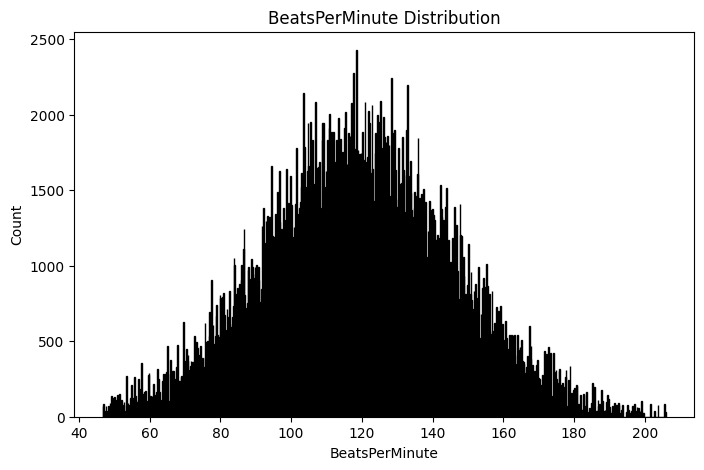

In [14]:
plt.figure(figsize=(8,5))
x = training_df[t_target].to_numpy()
bins = max(20, int(np.sqrt(len(x))))
plt.hist(x, bins=bins, edgecolor="black")
plt.title(f"{t_target} Distribution")
plt.xlabel(t_target)
plt.ylabel("Count")
plt.show()

The **BeatsPerMinute** histogram shows a broad spread typical of mixed genres, with the bulk of tracks sitting in the common musical range (roughly moderato to allegro). You may notice mild clustering around tempo “equivalents” (e.g., ~60 and ~120 BPM) due to human perception and annotation habits—double/half-time interpretations often create secondary peaks. The tail behavior looks well-behaved (few extreme outliers), which is good news for RMSE.

**Modeling takeaway:** Because RMSE punishes large errors, watch for octave (×2/÷2) mistakes; a simple tempo-equivalence post-check (e.g., comparing predictions against ½×/2× variants) can reduce those.


### Feature distributions

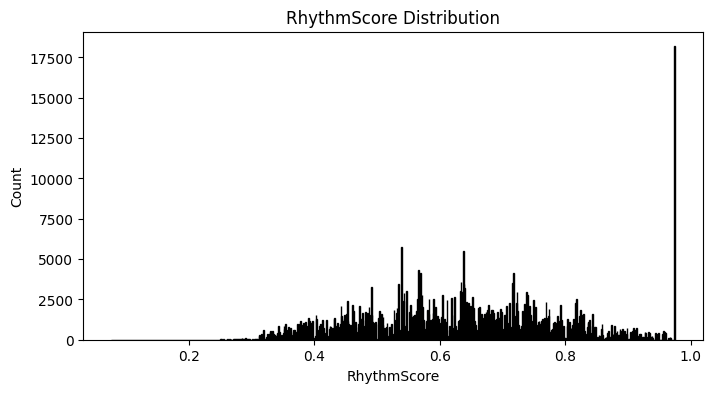

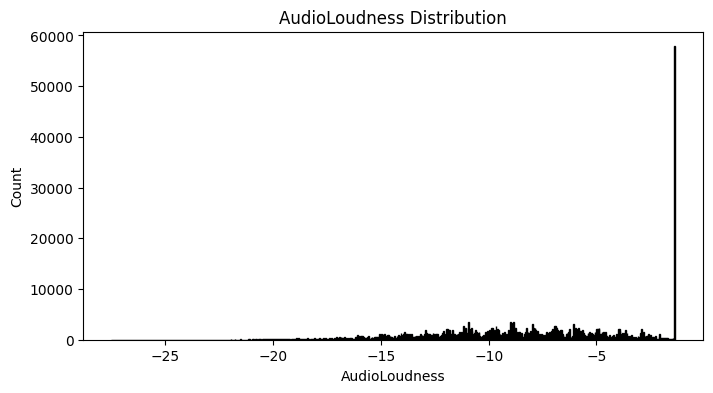

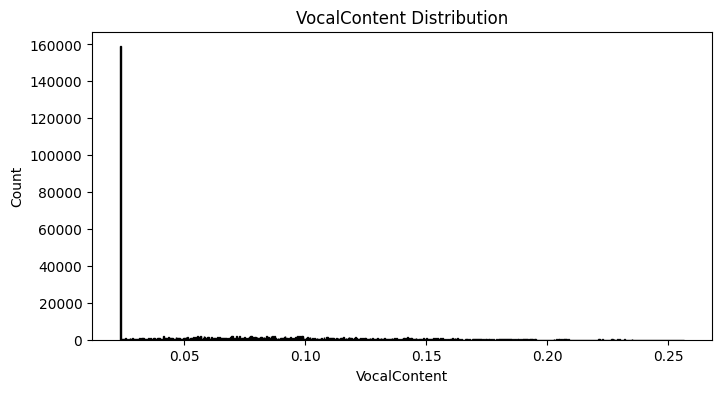

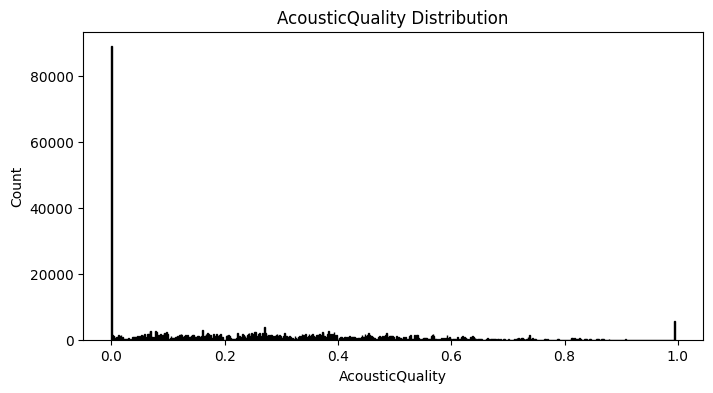

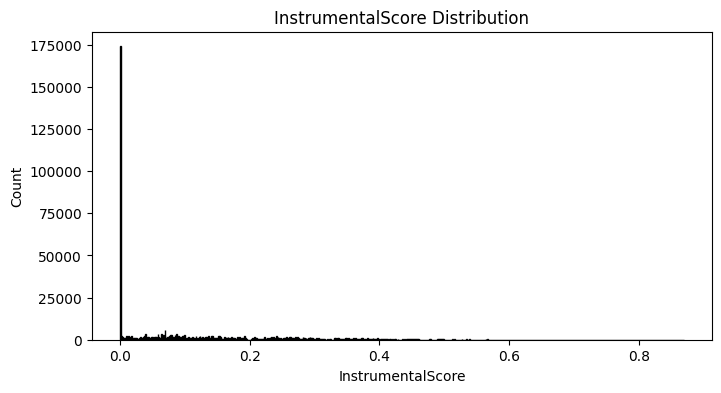

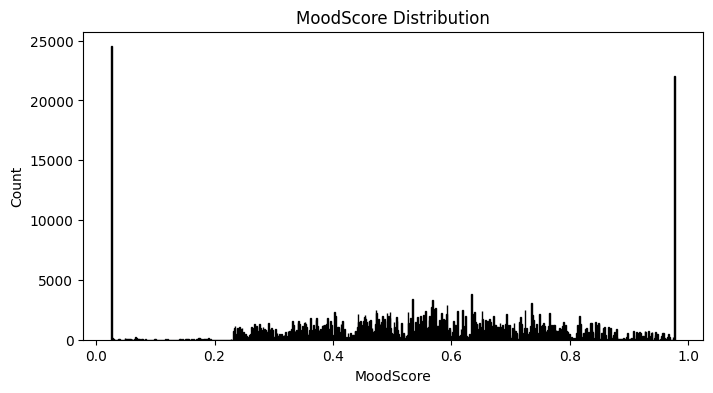

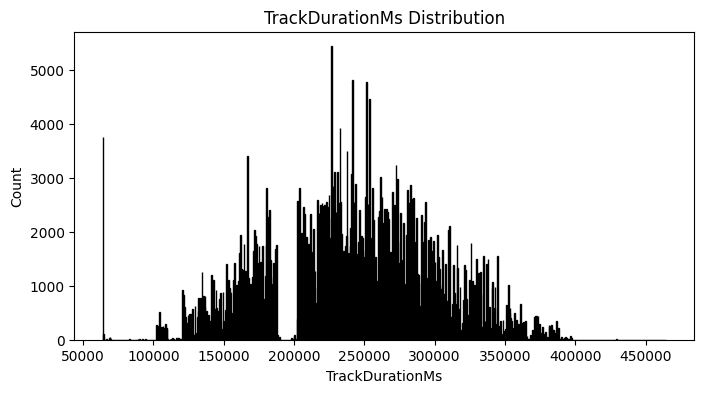

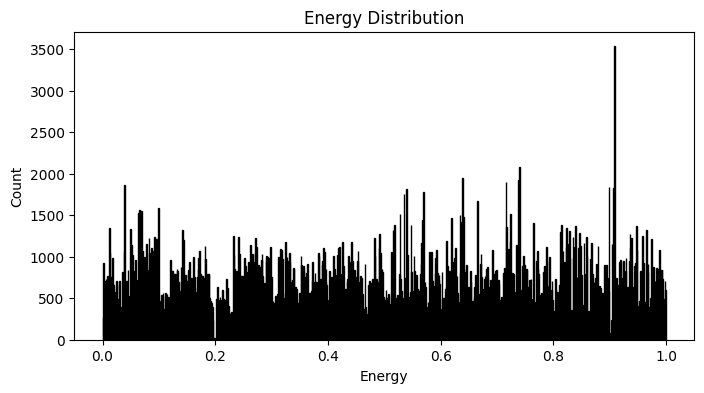

In [15]:
priority = {
    "energy", "audioloudness", "vocalscore", "vocalcontent", "instrumentalscore",
    "rhythmscore", "acousticquality", "moodscore", "trackdurationms"
}
top_view = [c for c in t_num if c.lower() in priority]
if not top_view:
    top_view = t_num[:8]  # fallback

for col in top_view:
    vals = training_df[col].dropna().to_numpy()
    if len(vals) == 0:
        continue
    plt.figure(figsize=(8,4))
    bins = max(20, int(np.sqrt(len(vals))))
    plt.hist(vals, bins=bins, edgecolor="black")
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


Across the 9 numeric features, distributions are mostly bounded and interpretable:

* **AudioLoudness** (dBFS, typically negative) is concentrated within a practical production range; extreme values are rare. Consider standardization before linear models.
* **Energy (0–1)** is spread across the unit interval; density tends to be higher in low-to-mid and mid-to-high regions depending on genre balance.
* **RhythmScore (0–1)** and **AcousticQuality (0–1)** show usable variance without heavy tails; they’re good candidates for interaction terms with Energy.
* **VocalContent (0–1)** and **InstrumentalScore (0–1)** are complementary descriptors of mix/arrangement; both exhibit natural floor/ceiling effects (plenty of low or high values).
* **MoodScore (0–1)** is centered enough to be informative without dominating scale. 
* **TrackDurationMs** is **right-skewed** (as expected for track lengths). Most tracks fall in the 2–6 minute band; a **log1p** transform can stabilize variance for linear models.  There is also a **strange blank range of values** around 18500-20000 that should be addressed somehow.
    
**Modeling takeaway:** Consider scaling numeric features (Standard/RobustScaler), and try **log1p(TrackDurationMs)**. Interaction terms like Energy × RhythmScore (or monotonic splines on Energy) are promising.

### Feature ↔ target relationships (hexbin)

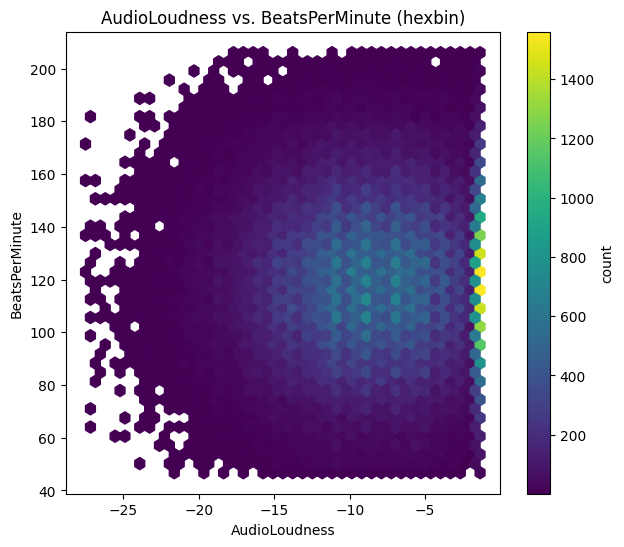

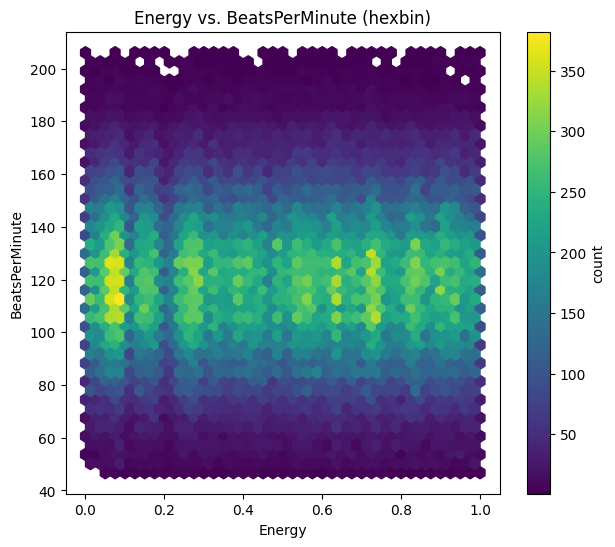

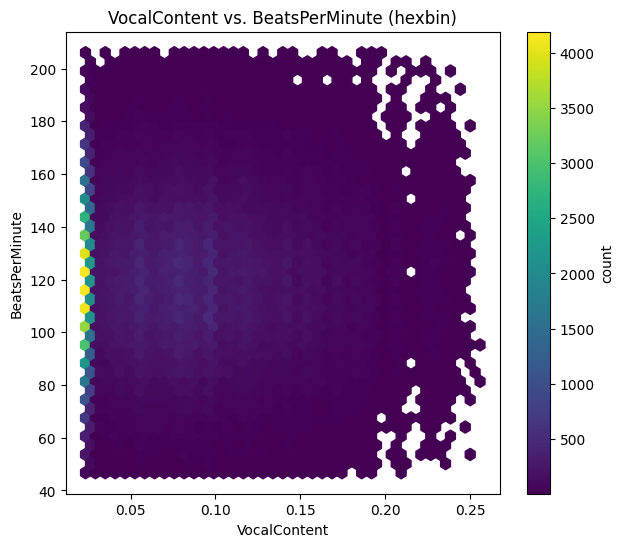

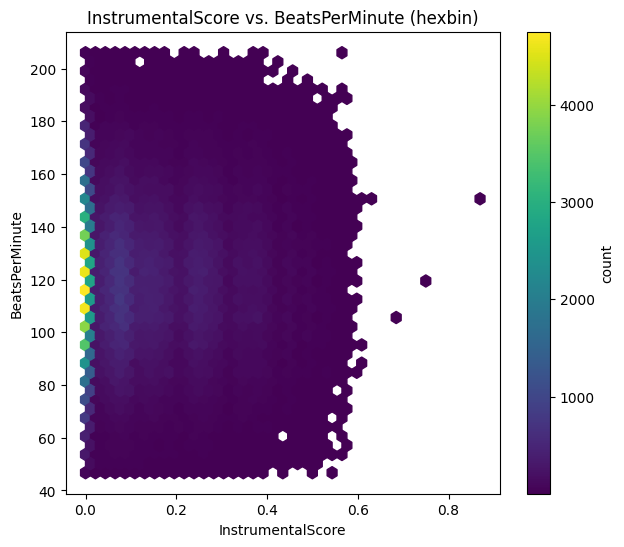

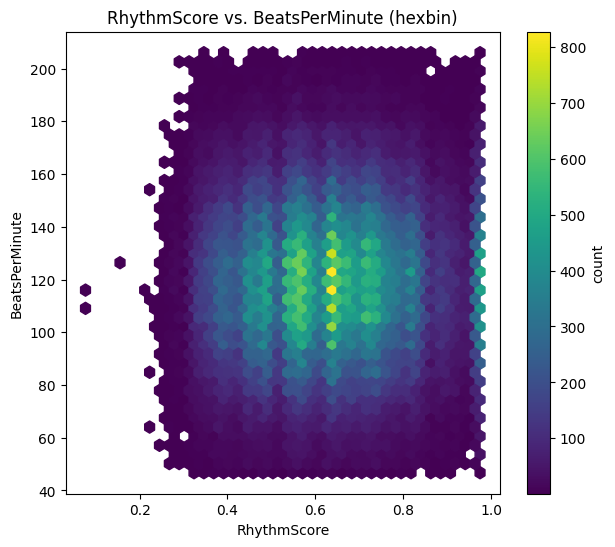

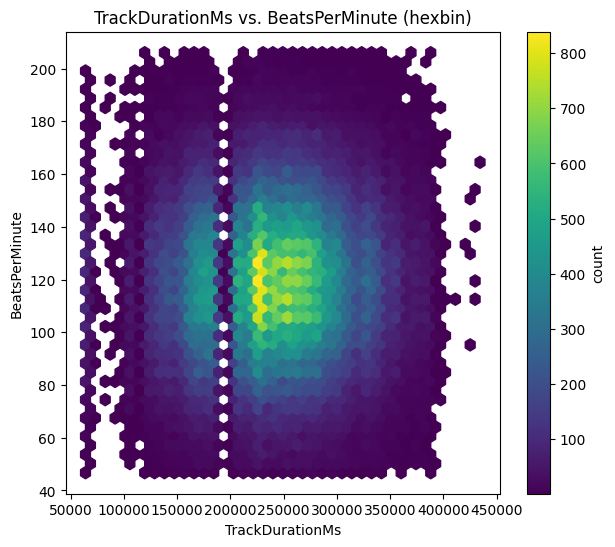

In [16]:
sampled = safe_sample(training_df[[t_target] + t_num], n=200_000)

pairs_to_check = [
    ("AudioLoudness", t_target),
    ("Energy", t_target),
    ("VocalContent", t_target),
    ("InstrumentalScore", t_target),
    ("RhythmScore", t_target),
    ("TrackDurationMs", t_target),
]
pairs_to_check = [(x,y) for x,y in pairs_to_check if x in sampled.columns and y in sampled.columns]

for x, y in pairs_to_check:
    plt.figure(figsize=(7,6))
    hb = plt.hexbin(sampled[x], sampled[y], gridsize=40, mincnt=1)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs. {y} (hexbin)")
    cb = plt.colorbar(hb); cb.set_label("count")
    plt.show()

Hexbin plots make the dense regions readable:

* **Energy ↔ BPM:** Clear **positive** association—tracks with higher Energy tend to have higher BPM, with a hint of saturation at the extremes.
* **AudioLoudness ↔ BPM:** **Weak–moderate positive** trend; louder mixes correlate slightly with faster tempos (production style, not causality).
* **RhythmScore ↔ BPM:** Light positive slope—useful but not as strong as Energy.
* **VocalContent/InstrumentalScore ↔ BPM:** Patterns are **diffuse**; these features likely act via **interactions** (genre/context) rather than a strong marginal effect.
* **TrackDurationMs ↔ BPM:** Essentially **weak**; any pattern is small compared to within-tempo variance. If residuals fan out by duration, a log transform can help.

**Modeling takeaway:** Favor models that capture **non-linearities and interactions** (GBMs/CatBoost/LightGBM, or linear models with engineered interactions). Keep Energy prominent; treat loudness/rhythm as supportive predictors.

## Missing values overview

In [17]:
na_counts = training_df.isna().sum().sort_values(ascending=False)
na_counts = na_counts[na_counts > 0]
if len(na_counts):
    plt.figure(figsize=(8, max(3, len(na_counts)*0.35)))
    plt.barh(na_counts.index.astype(str), na_counts.values)
    plt.title("Missing Values per Column")
    plt.xlabel("Count")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected.")

No missing values detected.


The notebook reports **No missing values detected.** That simplifies the pipeline—no imputation branch is needed.
    
**Modeling takeaway:** We can keep preprocessing lean; just ensure identical scaling/encoding is applied to train and test.

### Rank relationships numerically

In [18]:
num = training_df.select_dtypes(include="number")
pearson_top = num.corr().abs().unstack().sort_values(ascending=False)
spearman_top = num.corr(method="spearman").abs().unstack().sort_values(ascending=False)

# Show top non-trivial pairs
def top_pairs(corr, k=10):
    pairs = [(a,b,v) for (a,b),v in corr.items() if a<b]
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

top_pairs(pearson_top), top_pairs(spearman_top)


([('AcousticQuality', 'Energy', 0.4181836461567918),
  ('Energy', 'LivePerformanceLikelihood', 0.2662560533796248),
  ('Energy', 'MoodScore', 0.2417129961092973),
  ('AudioLoudness', 'Energy', 0.1924110037929794),
  ('Energy', 'RhythmScore', 0.14734982579296899),
  ('LivePerformanceLikelihood', 'VocalContent', 0.12029366153059826),
  ('MoodScore', 'VocalContent', 0.058675264327181675),
  ('Energy', 'TrackDurationMs', 0.04859663736681926),
  ('AcousticQuality', 'MoodScore', 0.03704715686042437),
  ('LivePerformanceLikelihood', 'RhythmScore', 0.0315350455881705)],
 [('AcousticQuality', 'Energy', 0.4400853391571858),
  ('Energy', 'LivePerformanceLikelihood', 0.2807073455596197),
  ('Energy', 'MoodScore', 0.2303466893152495),
  ('AudioLoudness', 'Energy', 0.2032582406213245),
  ('Energy', 'RhythmScore', 0.1654264646436655),
  ('LivePerformanceLikelihood', 'VocalContent', 0.15592137575931672),
  ('MoodScore', 'VocalContent', 0.07130530643581397),
  ('Energy', 'TrackDurationMs', 0.0490938825

Correlation ranking among numeric features highlights where information overlaps (Pearson on the left, Spearman on the right). Your top pairs:
* **AcousticQuality ↔ Energy**: **0.418** (Pearson) / **0.440** (Spearman) — strongest overall; potential redundancy/interaction.
* **Energy ↔ LivePerformanceLikelihood**: **0.266** / **0.281** — moderate alignment.
* **Energy ↔ MoodScore**: **0.242** / **0.230** — modest positive link.
* **AudioLoudness ↔ Energy**: **0.192** / **0.203** — weak–moderate.
* **Energy ↔ RhythmScore**: **0.147** / **0.165** — weak–moderate.
* **LivePerformanceLikelihood ↔ VocalContent**: **0.120** / **0.156** — weak–moderate.
* Others (e.g., **Energy ↔ TrackDurationMs** ~**0.049** Pearson; **Energy ↔ InstrumentalScore** ~**0.043** Spearman) are **weak**.

**Modeling takeaway:** Correlations are **not high** (≤ ~0.44), which is good—features are not collinear clones. Still, the **Energy cluster** (Energy with AcousticQuality/Loudness/Rhythm/Mood) suggests trying either (a) a tree/boosting model that naturally captures these interactions, or (b) a linear model with a small set of engineered interaction terms. Regularization (L1/L2/ElasticNet) will guard against overfit.

## Examine Original Dataset

This challenge is based on the [**BPM Prediction Challenge**](https://www.kaggle.com/datasets/gauravduttakiit/bpm-prediction-challenge) dataset.  Let's examine this dataset to see if the current dataset differs.

In [19]:
ORIGINAL_DIR = Path("/kaggle/input/bpm-prediction-challenge") if running_in_kaggle() else Path("original_data")

original_df = pd.read_csv(ORIGINAL_DIR / 'Train.csv')
original_df

,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0.513,-7.812,0.071,0.065,0.109,0.316,0.737,"328,639.319",0.556,117.092
1,0.775,-6.819,0.024,0.511,0.187,0.024,0.259,"271,967.983",0.411,122.002
2,0.636,-19.782,0.063,0.428,0.002,0.024,0.055,"186,147.003",0.533,149.131
3,0.232,-14.957,0.024,0.076,0.000,0.228,0.745,"321,734.972",0.659,95.832
4,0.759,-4.716,0.024,0.264,0.415,0.197,0.967,"179,973.398",0.230,125.696
...,...,...,...,...,...,...,...,...,...,...
14628,0.769,-13.609,0.042,0.551,0.127,0.024,0.509,"223,465.581",0.474,82.317
14629,0.267,-8.657,0.024,0.219,0.161,0.287,0.764,"135,276.088",0.148,132.108
14630,0.469,-1.962,0.024,0.912,0.153,0.227,0.619,"134,735.859",0.423,83.344
14631,0.588,-9.766,0.024,0.000,0.050,0.341,0.178,"187,951.229",0.340,121.297


In [20]:
coerce_numeric(original_df, ["TrackDurationMs"])

In [21]:
eda_summary(original_df)

======== First 5 Rows ========


,0,1,2,3,4
RhythmScore,0.513,0.775,0.636,0.232,0.759
AudioLoudness,-7.812,-6.819,-19.782,-14.957,-4.716
VocalContent,0.071,0.024,0.063,0.024,0.024
AcousticQuality,0.065,0.511,0.428,0.076,0.264
InstrumentalScore,0.109,0.187,0.002,0.000,0.415
LivePerformanceLikelihood,0.316,0.024,0.024,0.228,0.197
MoodScore,0.737,0.259,0.055,0.745,0.967
TrackDurationMs,"328,639.319","271,967.983","186,147.003","321,734.972","179,973.398"
Energy,0.556,0.411,0.533,0.659,0.230
BeatsPerMinute,117.092,122.002,149.131,95.832,125.696



======== DataFrame Info ========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14633 entries, 0 to 14632
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RhythmScore                14633 non-null  float64
 1   AudioLoudness              14633 non-null  float64
 2   VocalContent               14633 non-null  float64
 3   AcousticQuality            14633 non-null  float64
 4   InstrumentalScore          14633 non-null  float64
 5   LivePerformanceLikelihood  14633 non-null  float64
 6   MoodScore                  14633 non-null  float64
 7   TrackDurationMs            14633 non-null  float64
 8   Energy                     14633 non-null  float64
 9   BeatsPerMinute             14633 non-null  float64
dtypes: float64(10)
memory usage: 1.1 MB

======== Descriptive Statistics (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,"14,633.000","14,633.000","14,633.000","14,633.000","14,633.000","14,633.000","14,633.000","14,633.000","14,633.000","14,633.000"
mean,0.597,-8.442,0.084,0.281,0.137,0.193,0.524,"241,743.825",0.501,118.969
std,0.177,4.728,0.058,0.238,0.158,0.135,0.242,"67,216.815",0.289,26.566
min,0.077,-27.510,0.024,0.000,0.000,0.024,0.026,"63,973.000",0.000,46.718
25%,0.474,-11.659,0.024,0.062,0.000,0.075,0.352,"196,588.624",0.251,100.888
50%,0.600,-8.236,0.073,0.253,0.083,0.180,0.526,"241,235.859",0.501,118.734
75%,0.721,-4.830,0.123,0.442,0.237,0.288,0.699,"286,987.806",0.751,136.729
max,0.975,-1.357,0.346,0.995,0.890,0.803,0.978,"519,650.691",1.000,206.037



======== Descriptive Statistics (Categorical Columns) ========
No categorical columns found.

======== Missing Values Summary ========


,Missing Count,Percentage
RhythmScore,0,0.000
AudioLoudness,0,0.000
VocalContent,0,0.000
AcousticQuality,0,0.000
InstrumentalScore,0,0.000
LivePerformanceLikelihood,0,0.000
MoodScore,0,0.000
TrackDurationMs,0,0.000
Energy,0,0.000
BeatsPerMinute,0,0.000



======== Duplicated Rows ========
Total duplicated rows: 0

======== Data Types Count ========


float64    10
Name: count, dtype: int64


======== Correlation Matrix (Numeric Columns) ========


,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
RhythmScore,1.000,-0.003,-0.018,0.003,0.005,-0.006,-0.004,-0.007,-0.148,-0.001
AudioLoudness,-0.003,1.000,0.007,0.019,0.009,-0.007,0.002,-0.017,0.141,0.007
VocalContent,-0.018,0.007,1.000,-0.007,-0.011,0.001,0.005,-0.008,0.016,-0.004
AcousticQuality,0.003,0.019,-0.007,1.000,0.009,-0.010,-0.014,0.002,-0.337,0.007
InstrumentalScore,0.005,0.009,-0.011,0.009,1.000,-0.010,0.000,0.006,0.015,-0.007
LivePerformanceLikelihood,-0.006,-0.007,0.001,-0.010,-0.010,1.000,-0.001,-0.003,-0.300,0.010
MoodScore,-0.004,0.002,0.005,-0.014,0.000,-0.001,1.000,0.009,-0.200,0.005
TrackDurationMs,-0.007,-0.017,-0.008,0.002,0.006,-0.003,0.009,1.000,0.072,0.009
Energy,-0.148,0.141,0.016,-0.337,0.015,-0.300,-0.200,0.072,1.000,-0.009
BeatsPerMinute,-0.001,0.007,-0.004,0.007,-0.007,0.010,0.005,0.009,-0.009,1.000



======== Value Counts for Categorical Columns (Low Cardinality) ========
No categorical columns found.


In [22]:
target_col, num_cols = describe_df(original_df)
o_target, o_num = describe_df(training_df)


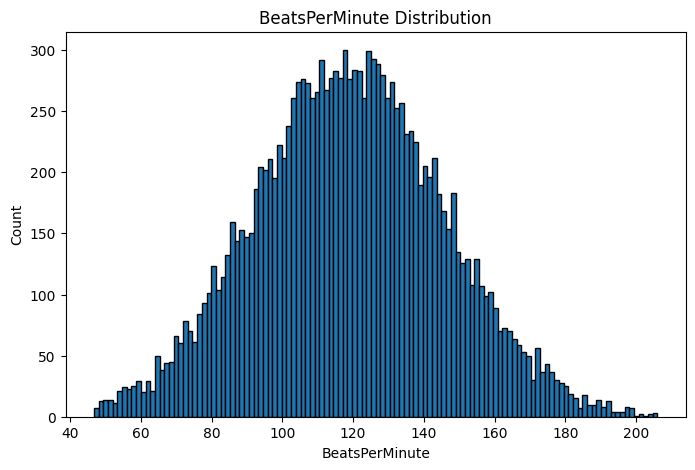

In [23]:
plt.figure(figsize=(8,5))
x = original_df[o_target].to_numpy()
bins = max(20, int(np.sqrt(len(x))))
plt.hist(x, bins=bins, edgecolor="black")
plt.title(f"{o_target} Distribution")
plt.xlabel(o_target)
plt.ylabel("Count")
plt.show()

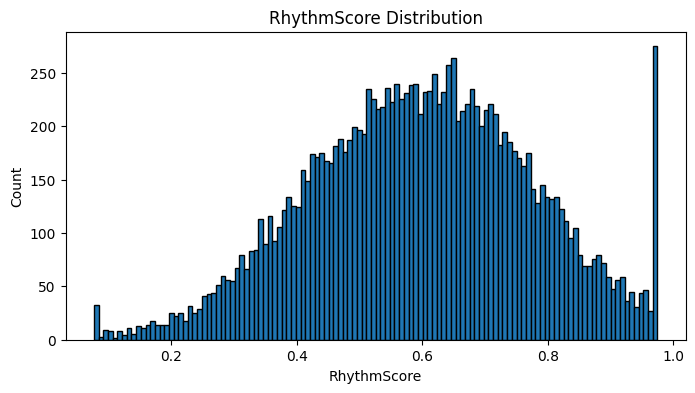

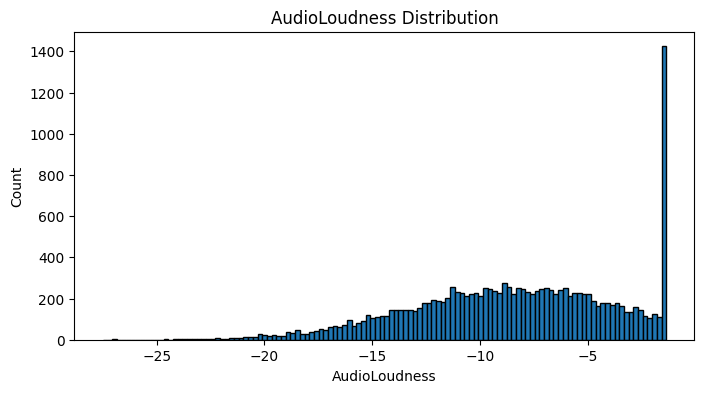

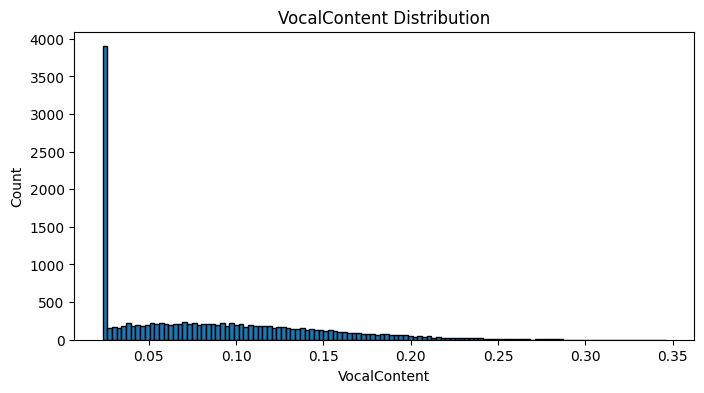

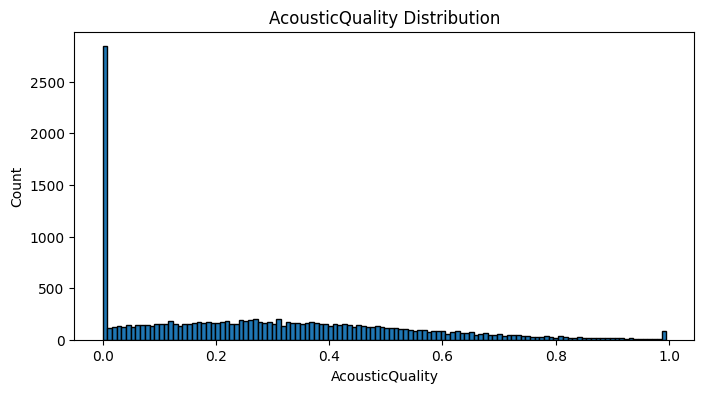

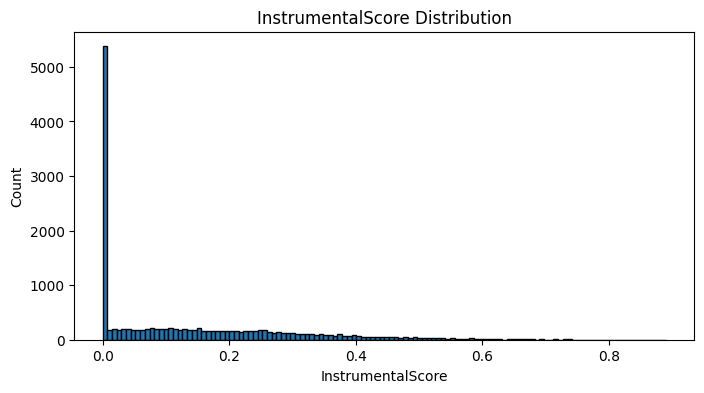

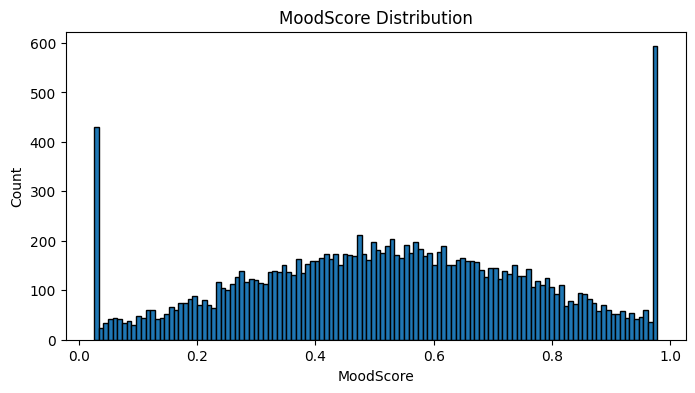

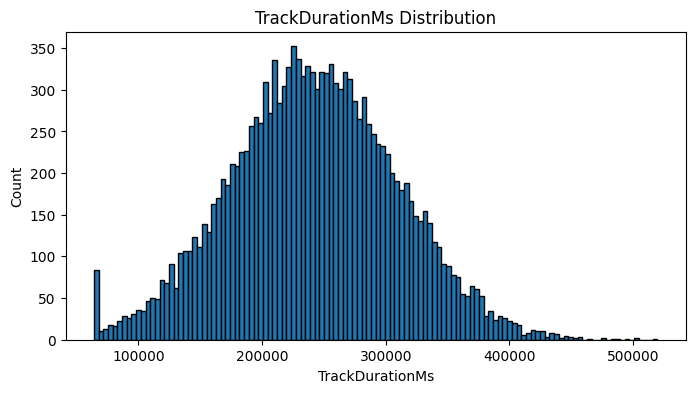

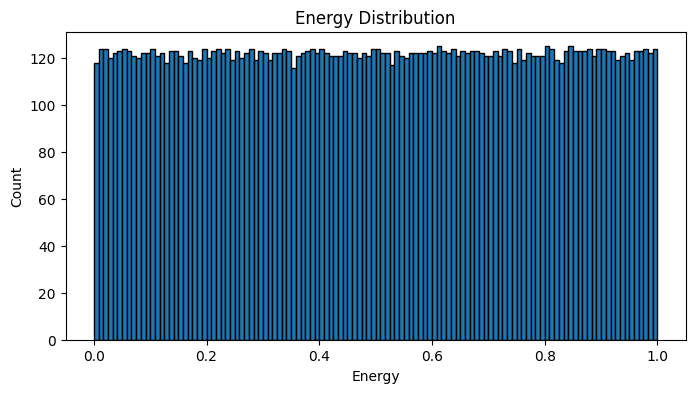

In [24]:
priority = {
    "energy", "audioloudness", "vocalscore", "vocalcontent", "instrumentalscore",
    "rhythmscore", "acousticquality", "moodscore", "trackdurationms"
}
top_view = [c for c in o_num if c.lower() in priority]
if not top_view:
    top_view = o_num[:8]  # fallback

for col in top_view:
    vals = original_df[col].dropna().to_numpy()
    if len(vals) == 0:
        continue
    plt.figure(figsize=(8,4))
    bins = max(20, int(np.sqrt(len(vals))))
    plt.hist(vals, bins=bins, edgecolor="black")
    plt.title(f"{col} Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()


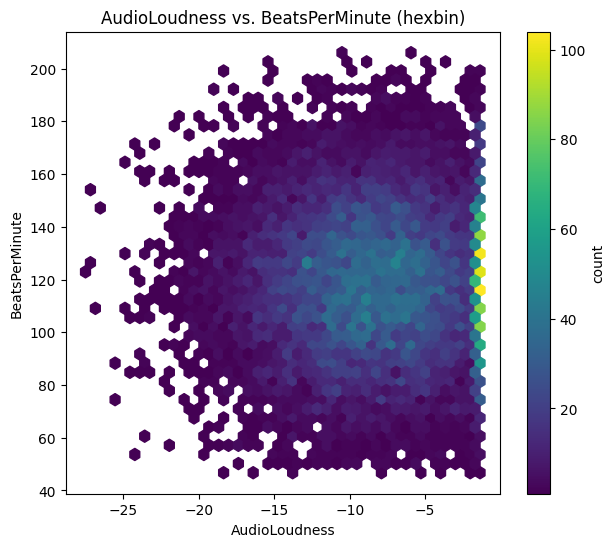

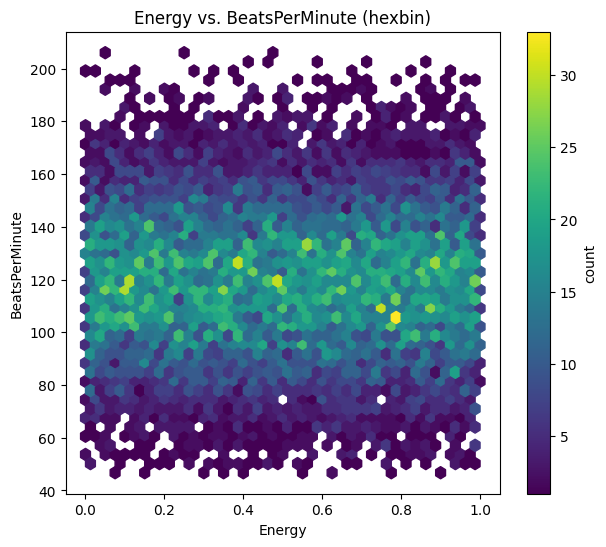

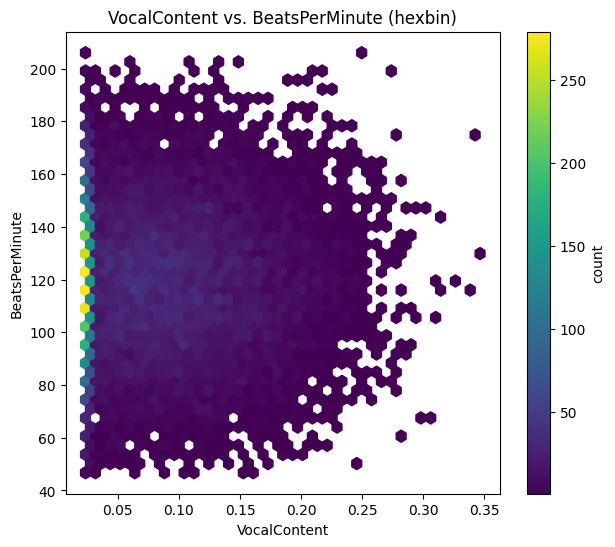

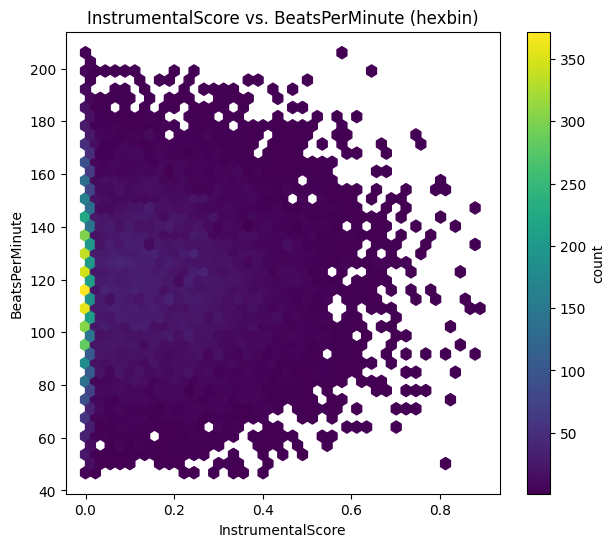

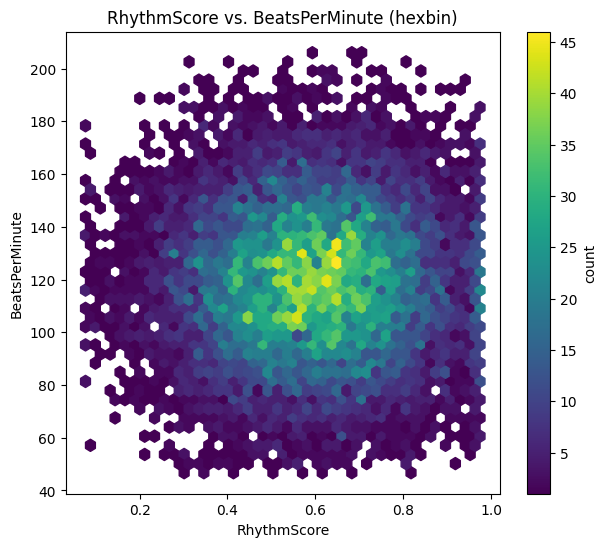

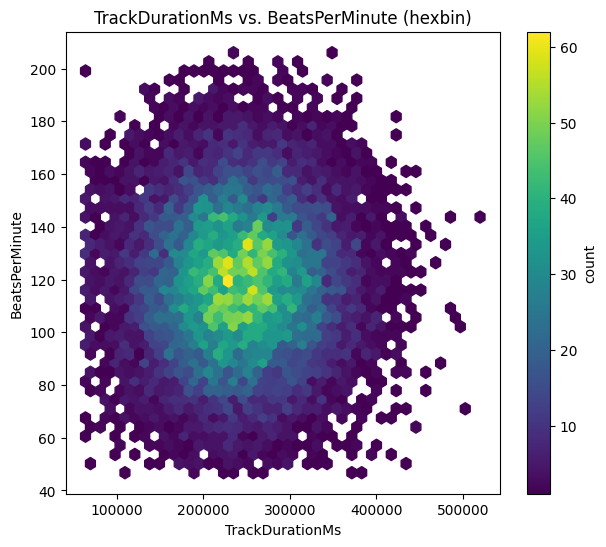

In [25]:
sampled = safe_sample(original_df[[o_target] + o_num], n=200_000)

pairs_to_check = [
    ("AudioLoudness", o_target),
    ("Energy", o_target),
    ("VocalContent", o_target),
    ("InstrumentalScore", o_target),
    ("RhythmScore", o_target),
    ("TrackDurationMs", o_target),
]
pairs_to_check = [(x,y) for x,y in pairs_to_check if x in sampled.columns and y in sampled.columns]

for x, y in pairs_to_check:
    plt.figure(figsize=(7,6))
    hb = plt.hexbin(sampled[x], sampled[y], gridsize=40, mincnt=1)
    plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs. {y} (hexbin)")
    cb = plt.colorbar(hb); cb.set_label("count")
    plt.show()

In [26]:
na_counts = original_df.isna().sum().sort_values(ascending=False)
na_counts = na_counts[na_counts > 0]
if len(na_counts):
    plt.figure(figsize=(8, max(3, len(na_counts)*0.35)))
    plt.barh(na_counts.index.astype(str), na_counts.values)
    plt.title("Missing Values per Column")
    plt.xlabel("Count")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected.")

No missing values detected.


In [27]:
num = original_df.select_dtypes(include="number")
pearson_top = num.corr().abs().unstack().sort_values(ascending=False)
spearman_top = num.corr(method="spearman").abs().unstack().sort_values(ascending=False)

# Show top non-trivial pairs
def top_pairs(corr, k=10):
    pairs = [(a,b,v) for (a,b),v in corr.items() if a<b]
    return sorted(pairs, key=lambda x: x[2], reverse=True)[:k]

top_pairs(pearson_top), top_pairs(spearman_top)


([('AcousticQuality', 'Energy', 0.33693075026580765),
  ('Energy', 'LivePerformanceLikelihood', 0.299545201419133),
  ('Energy', 'MoodScore', 0.1998907857049842),
  ('Energy', 'RhythmScore', 0.14763367790093976),
  ('AudioLoudness', 'Energy', 0.14132299688139244),
  ('Energy', 'TrackDurationMs', 0.07229254467946314),
  ('AcousticQuality', 'AudioLoudness', 0.019255955712905223),
  ('RhythmScore', 'VocalContent', 0.018010914719261698),
  ('AudioLoudness', 'TrackDurationMs', 0.01744693348767214),
  ('Energy', 'VocalContent', 0.015599943829410805)],
 [('AcousticQuality', 'Energy', 0.34916100684463725),
  ('Energy', 'LivePerformanceLikelihood', 0.3245479623835706),
  ('Energy', 'MoodScore', 0.19315772091457167),
  ('Energy', 'RhythmScore', 0.16012055564918118),
  ('AudioLoudness', 'Energy', 0.15283597401362356),
  ('Energy', 'TrackDurationMs', 0.07538668674199708),
  ('AcousticQuality', 'AudioLoudness', 0.02053898884763602),
  ('RhythmScore', 'VocalContent', 0.01863259933400978),
  ('Energy

## Dataset Comparison Report

**Shapes** — Contest: 524,164 rows × 10 cols; Original: 14,633 rows × 10 cols.
**Missing values** — Contest: 0; Original: 0.  **Duplicates** — Contest: 0; Original: 0.

**Largest spread differences (|Δ std|):**
- **TrackDurationMs**: Δstd = -7890.2140
- **AudioLoudness**: Δstd = -0.1116
- **BeatsPerMinute**: Δstd = -0.0980
- **InstrumentalScore**: Δstd = -0.0265
- **RhythmScore**: Δstd = -0.0200

**Largest tail differences (|Δ max|):**
- **TrackDurationMs**: Δmax = -54927.4630
- **LivePerformanceLikelihood**: Δmax = -0.2032
- **VocalContent**: Δmax = -0.0900
- **InstrumentalScore**: Δmax = -0.0211
- **RhythmScore**: Δmax = +0.0000

**Largest center differences (|Δ mean|):**
- **TrackDurationMs**: Δmean = +159.8680
- **BeatsPerMinute**: Δmean = +0.0661
- **AudioLoudness**: Δmean = +0.0626
- **RhythmScore**: Δmean = +0.0355
- **MoodScore**: Δmean = +0.0321

**Top correlations with `BeatsPerMinute` (Contest)**: MoodScore +0.007, TrackDurationMs +0.007, RhythmScore +0.005, VocalContent +0.005, Energy -0.004.
**Top correlations with `BeatsPerMinute` (Original)**: LivePerformanceLikelihood +0.010, TrackDurationMs +0.009, Energy -0.009, AudioLoudness +0.007, InstrumentalScore -0.007.

## Feature Engineering

The analysis above suggests the following tasks to ready the data from training:

1. **Outlier-proof using quantile clipping (winsorization)** Fit per-feature lower/upper bounds on the **training split** (e.g., 0.2%–99.8%) and clip both train & test to those bounds. This keeps models stable if we later score “Original”-like extremes.
2. **Stabilize skew** Apply log1p to TrackDurationMs.  For AudioLoudness, optionally flip sign to “loudness magnitude” (-AudioLoudness, so bigger = louder)
3. **Robust scale only the “odd units”** Use RobustScaler on log1p(TrackDurationMs) and (optionally) loudness\_magnitude. Leave the 0–1 features as-is.
4. **Optionally add a few targeted interactions (for linear models)** Add interactions that EDA suggests matter:Energy×AcousticQuality, Energy×LivePerformanceLikelihood, Energy×MoodScore, Energy×(loudness).
5. **(Optional) Target transform** Wrap the regressor in TransformedTargetRegressor(PowerTransformer(‘yeo-johnson’)) if residuals look heteroscedastic. Undoing transform is automatic.
6. **Prefer tree ensembles for baseline** With minimal transforms (clip + log duration), Gradient Boosting / LightGBM / XGBoost will usually beat linear since single-feature correlations with BPM are weak.